In [108]:
%reset

import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse

# Exercise 1

## A: Power Reflection

In [2]:
N = 32
n1 = 3.5
n2 = 3.1
ld = 900         # nm

L1 = 64.3           # nm
L2 = 77.6           # nm

xlim0 = 800         # nm
xlim1 = 1000        # nm

In [11]:
L2 = ld/(4*n2)
L2

72.58064516129032

In [12]:
# Power reflection
st = 1                                      # nm
lambdas = np.arange(xlim0, xlim1+st, st)    # nm

Rtot = []
Ttot = []
for l in lambdas:
    k0 = 2*np.pi/l
    T = lambda n1, n2 : 1/(2*n2) * np.array([[n2 + n1, n2 - n1], [n2 - n1, n2 + n1]])
    TL = lambda L, n: np.array([[np.exp(1j*n*k0*L), 0], [0, np.exp(-1j*n*k0*L)]])

    # build the unit transfer matrix
    Tunit = (np.matmul(np.matmul(np.matmul(TL(L2, n2), T(n1, n2)), TL(L1, n1)), T(n2, n1)))

    Tt = np.identity(len(Tunit))
    for i in range(N):
        Tt = np.matmul(Tt, Tunit)

    Rtot.append(np.abs(np.divide(Tt[0][1], Tt[1][1]))**2)
    Ttot.append(np.absolute(Tt[0][0] - np.divide((Tt[0][1] * Tt[1][0]), Tt[1][1]))**2)

Rtot = np.array(Rtot)
Ttot = np.array(Ttot)

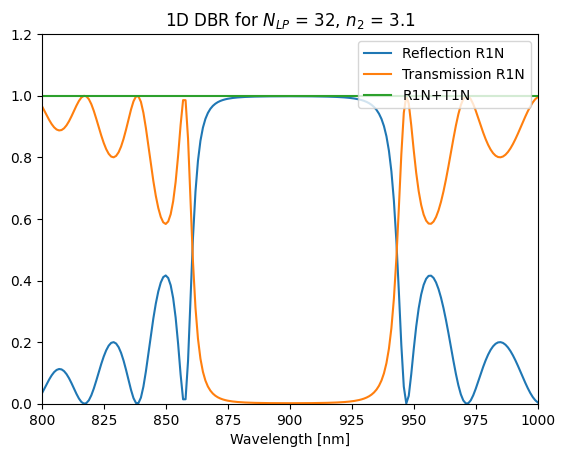

In [13]:
plt.figure()
plt.plot(lambdas, Rtot, label="Reflection R1N")
plt.plot(lambdas, Ttot, label="Transmission R1N")
plt.plot(lambdas, Rtot + Ttot, label="R1N+T1N")
plt.xlabel("Wavelength [nm]")
plt.xlim([xlim0, xlim1])
plt.ylim([0, 1.2])
plt.title("1D DBR for $N_{LP}$ = " + str(N) + ", $n_2$ = " + str(n2))
plt.legend(loc='upper right')
plt.show()

## B: Field profile for a DBR

In [109]:
n1 = 3.5
n2 = 2.9

N = 32

lda = 965             # nm
k0 = 2*np.pi/lda

L1 = 900/(4*n1)
L2 = 900/(4*n2)

AN = np.array([1, 0]).reshape([2,1])

zlim0 = 0                               # nm
zlim1 = (L1+L2)*N+L1                    # nm

zr = np.linspace(0, zlim1, 975)         # nm

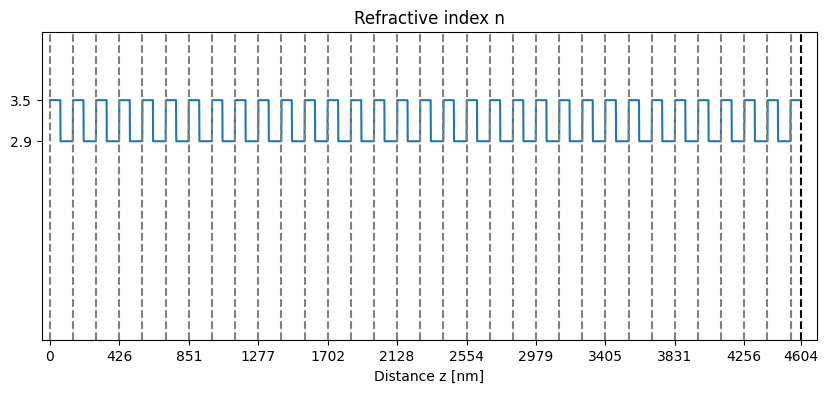

In [110]:
x = [i for i in np.arange(zlim0, zlim1, (L1+L2)/100)]
y = [n1 if i % (L1+L2) < L1 else n2 for i in np.arange(0, N*(L1+L2)+L1, (L1+L2)/100)]

plt.figure(figsize=(10,4))
plt.plot(x, y)
plt.axvline(x=max(zr), color="black", linestyle="--")
for hh in np.arange(0, max(zr)+L1, L1+L2):
    plt.axvline(x=hh, color="gray", linestyle="--")
plt.xlim([-50, 4700])
plt.xlabel("Distance z [nm]")
plt.xticks(np.append(np.arange(zlim0, zlim1, 3*(L1+L2)), zlim1))
plt.yticks([n1, n2])
plt.ylim([0, 4.5])
plt.title("Refractive index n")
plt.show()

Calculate the field at point 0: $A_0$

In [111]:
T = lambda n1, n2 : 1/(2*n2) * np.array([[n2 + n1, n2 - n1], [n2 - n1, n2 + n1]])
TL = lambda L, n: np.array([[np.exp(1j*n*k0*L), 0.], [0., np.exp(-1j*n*k0*L)]], dtype=np.complex_)

T_12 = T(n1, n2)
T_21 = T(n2, n1)
T_L1 = TL(L1, n1)
T_L2 = TL(L2, n2)

In [112]:
T_per = T_21 @ T_L2 @ T_12 @ T_L1
T_tot = T_L1 @ T_21 @ np.linalg.matrix_power(T_per, N)
A0 = np.linalg.pinv(T_tot) @ AN

In [113]:
A0

array([[-0.08038408+1.0980215j ],
       [ 0.0142529 -0.07080341j]])

In [67]:
Etot = []

for z in zr:
    lz_r = z % (L1 + L2)            # remained distance from integer interval
    n = int((z)/(L1+L2))            # number of integer layers in between first and last part

    # calculate Tt matrix
    if z < L1:
        Tt = TL(z, n1)
    else:
        if lz_r < L1:
            Tt = TL(z, n1) @ np.linalg.matrix_power(T_per, n)
        else:
            Tt = TL(z-L1, n2) @ T_12 @ T_L1 @ np.linalg.matrix_power(T_per, n)
    
    # calculate the field at pos z
    A1z = Tt @ A0
    Etot.append(np.abs(A1z[0][0] + A1z[1][0]))
    
Etot = np.array(Etot)

In [114]:
LP = L1 + L2

A_1 = np.zeros((len(zr), 1), dtype=np.complex_)
B_1 = np.zeros((len(zr), 1), dtype=np.complex_)

j = 0

# First layer
while zr[j]  < L1:
    T_temp1 = TL(zr[j], n1)
    AB_1 = T_temp1 @ A0
    A_1[j, 0] = AB_1[0, 0]
    B_1[j, 0] = AB_1[1, 0]
    j += 1

T = T_12 @ T_L1

while zr[j] < LP:
    T_temp2 = TL(zr[j]-L1, n2) @ T
    AB_1 = T_temp2 @ A0
    A_1[j, 0] = AB_1[0, 0]
    B_1[j, 0] = AB_1[1, 0]
    j += 1

T = T_21 @ T_L2 @ T_12 @ T_L1

# Next layers
l = 1            # the index indicates the (previous) completed layer
i = j

while (i<=len(zr)) & ((l-1)<N):
    while (i<=len(zr)) & (zr[i] < (l*LP+L1)) & (zr[i] > l*LP):
        T_temp1 = TL(zr[i]-l*LP, n1) @ T
        AB_1 = T_temp1 @ A0
        A_1[i, 0] = AB_1[0, 0]
        B_1[i, 0] = AB_1[1, 0]
        i += 1
    
    T = T_12 @ T_L1 @ np.linalg.matrix_power(T_per, l)

    while (i<=len(zr)) & (zr[i] > (l*LP+L1)) & (zr[i] < ((l+1)*LP)):
        T_temp2 = TL(zr[i]-(l*LP + L1), n2) @ T
        AB_1 = T_temp2 @ A0
        A_1[i, 0] = AB_1[0, 0]
        B_1[i, 0] = AB_1[1, 0]
        i += 1
    
    T = np.linalg.matrix_power(T_per, l+1)
    l = l+1

Etot = np.abs(A_1+B_1)

In [39]:
T = lambda n1, n2 : 1/(2*n2) * np.array([[n2 + n1, n2 - n1], [n2 - n1, n2 + n1]])
TL = lambda L, n: np.array([[np.exp(1j*n*k0*L), 0], [0, np.exp(-1j*n*k0*L)]])
# build the unit transfer matrix
Tt = np.identity(2)
#                                       ((TL1 * T21) * TL2) * T12
Tunit = np.matmul(np.matmul(np.matmul(T(n2, n1), T(L2, n2)), T(n1, n2)), TL(L1, n1))
# Tunit = (np.matmul(np.matmul(np.matmul(T(n1, n2), TL(L2, n2)), T(n2, n1)), TL(L1, n1)))
for i in range(N):
    Tt = np.matmul(Tunit, Tt)
Tt = np.matmul(np.matmul(TL(L1, n1), T(n2, n1)), Tt)
Tts = sparse.csr_matrix(Tt)
Ttinv = np.linalg.pinv(Tts.toarray())

A10 = np.matmul(Ttinv, AN)
np.abs(A10[0][0] + A10[1][0])

1.4514953303395775e-23

$
T_t = 
     \begin{cases}
       T_{1}(z_{lr}) &\quad z < L_1\\
       T_{2}(z_{lr}-L_2) * (T_{12} * T_{L1} * T_{21} * T_{L2})^{N} * T_{12} * T_{L1} &\quad z > L_1\quad \&\quad z_{lr} < L_2 \\ 
       T_{1}(z_{lr}-L_1) * T_{21} * T_{L2} * (T_{12} * T_{L1} * T_{21} * T_{L2})^{N} * T_{12} * T_{L1} &\quad z > L_1\quad \&\quad z_{lr} > L_2 \\ 
     \end{cases}
$

with $N = (z-L_1)/(L_1+L_2), \, N\in\mathbb{N}$ and $z_{lr} =\!\!\mod{(z-L_1, L_1+L_2)}$

In [55]:
Etot = []

# Tunit = np.matmul(np.matmul(np.matmul(TL(L1, n1), T(n2, n1)), TL(L2, n2)), T(n1, n2))

for z in zr:
    # build the transfer matrix

    # we start from unity
    Tt = np.identity(2)

    lz_r = z % (L1 + L2)            # remained distance from integer interval
    n = int((z)/(L1+L2))         # number of integer layers in between first and last part

    for i in range(n):
        Tt = np.matmul(Tunit, Tt)

        
    if lz_r < L1:
        Tt = np.matmul(TL(lz_r, n1), Tt)
    else:
        Tt = np.matmul(np.matmul(np.matmul(TL(L1, n1), T(n2, n1)), TL(lz_r, n2)), Tt)

    A1z = np.matmul(Tt, A10)
    Etot.append(np.abs(A1z[0][0] + A1z[1][0]))
    
Etot = np.array(Etot)

NameError: name 'A10' is not defined

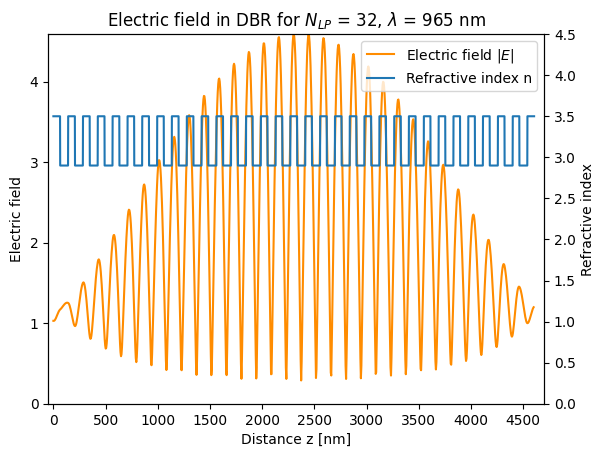

In [117]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

lns1 = ax1.plot(zr[:-1], Etot[:-1], color="darkorange", label=r"Electric field $|E|$")
lns2 = ax2.plot(x, y, label="Refractive index n")

ax1.set_xlabel("Distance z [nm]")
ax1.set_ylabel("Electric field")
ax2.set_ylabel("Refractive index")

plt.xticks(np.arange(0, max(zr), 500))
plt.xlim([-50, 4700])
ax1.set_ylim([0, max(Etot)])
ax2.set_ylim([0, 4.5])

plt.title("Electric field in DBR for $N_{LP}$ = " + str(N) + ", $\lambda$ = " + str(lda) + " nm")

# build legend
lns = lns1+lns2
labs = [ln.get_label() for ln in lns]
ax1.legend(lns, labs, loc='upper right')

plt.show()

# Exercise 2

C:\Users\amcar\AppData\Local\Temp\ipykernel_22512\686542429.py:38: ComplexWarning: Casting complex values to real discards the imaginary part
  r_1N[i] = -T_tot[1, 0]/T_tot[1, 1];
C:\Users\amcar\AppData\Local\Temp\ipykernel_22512\686542429.py:39: ComplexWarning: Casting complex values to real discards the imaginary part
  t_1N[i] = T_tot[0, 0] - (T_tot[0, 1]*T_tot[1, 0]/T_tot[1, 1])


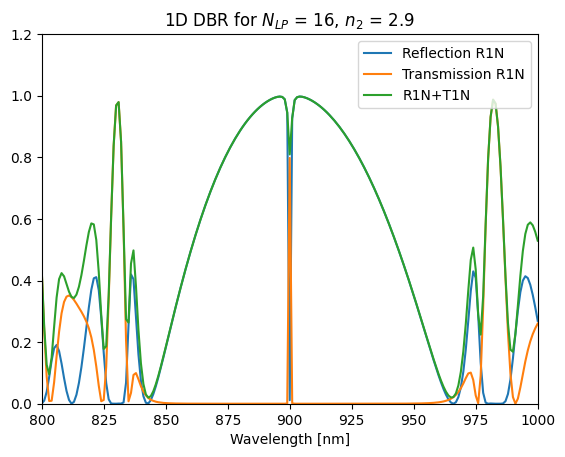

In [123]:
N_LP = 16
xlim0 = 800         # nm
xlim1 = 1000        # nm

L_cav = ld/n1

# Power reflection
st = 1                                      # nm
lambdas = np.arange(xlim0, xlim1+st, st)    # nm


r_1N = np.zeros(len(lambdas))
t_1N = np.zeros(len(lambdas))
R_1N = np.zeros(len(lambdas))
T_1N = np.zeros(len(lambdas))

for i, l in enumerate(lambdas):
    k0 = 2*np.pi/l
    T = lambda n1, n2 : 1/(2*n2) * np.array([[n2 + n1, n2 - n1], [n2 - n1, n2 + n1]])
    TL = lambda L, n: np.array([[np.exp(1j*n*k0*L), 0], [0, np.exp(-1j*n*k0*L)]])

    T_12 = T(n1, n2)
    T_21 = T(n2, n1)
    T_L1 = TL(L1, n1)
    T_L2 = TL(L2, n2)
    T_cav = TL(L_cav, n1)

    T_per = T_L2 @ T_12 @ T_L1 @ T_21
    T_per_inv = T_L1 @ T_21 @ T_L2 @ T_12

    T_tot = np.linalg.matrix_power(T_per_inv, N_LP) @ T_cav @ np.linalg.matrix_power(T_per, N_LP)

    # Power reflection and transmission
    
    n_N = n1;
    
    # Illuminate from front
    r_1N[i] = -T_tot[1, 0]/T_tot[1, 1];
    t_1N[i] = T_tot[0, 0] - (T_tot[0, 1]*T_tot[1, 0]/T_tot[1, 1])

    R_1N[i] = np.abs(r_1N[i])**2
    T_1N[i] = np.abs(t_1N[i])**2 * n_N/n1

plt.figure()
plt.plot(lambdas, R_1N, label="Reflection R1N")
plt.plot(lambdas, T_1N, label="Transmission R1N")
plt.plot(lambdas, R_1N + T_1N, label="R1N+T1N")
plt.xlabel("Wavelength [nm]")
plt.xlim([xlim0, xlim1])
plt.ylim([0, 1.2])
plt.title("1D DBR for $N_{LP}$ = " + str(N) + ", $n_2$ = " + str(n2))
plt.legend(loc='upper right')
plt.show()

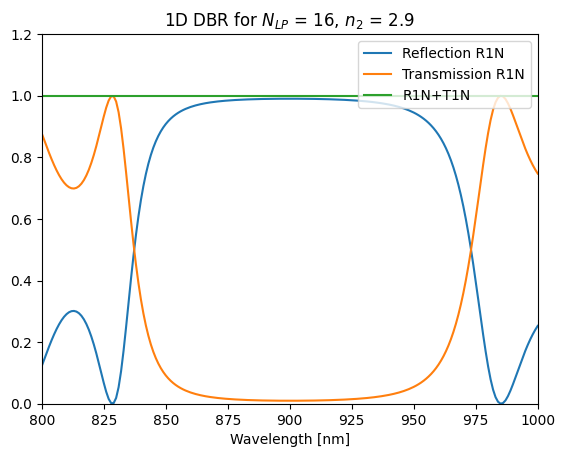

In [118]:
## A: Power Reflection
N = 16
n1 = 3.5
n2 = 2.9
ld = 900         # nm

L1 = 64.3           # nm
L2 = 77.6           # nm

xlim0 = 800         # nm
xlim1 = 1000        # nm


# Power reflection
st = 1                                      # nm
lambdas = np.arange(xlim0, xlim1+st, st)    # nm

Rtot = []
Ttot = []
for l in lambdas:
    k0 = 2*np.pi/l
    T = lambda n1, n2 : 1/(2*n2) * np.array([[n2 + n1, n2 - n1], [n2 - n1, n2 + n1]])
    TL = lambda L, n: np.array([[np.exp(1j*n*k0*L), 0], [0, np.exp(-1j*n*k0*L)]])

    # build the unit transfer matrix
    Tunit = (np.matmul(np.matmul(np.matmul(TL(L2, n2), T(n1, n2)), TL(L1, n1)), T(n2, n1)))

    Tt = np.identity(len(Tunit))
    for i in range(N):
        Tt = np.matmul(Tt, Tunit)

    Rtot.append(np.abs(np.divide(Tt[0][1], Tt[1][1]))**2)
    Ttot.append(np.absolute(Tt[0][0] - np.divide((Tt[0][1] * Tt[1][0]), Tt[1][1]))**2)

Rtot = np.array(Rtot)
Ttot = np.array(Ttot)
plt.figure()
plt.plot(lambdas, Rtot, label="Reflection R1N")
plt.plot(lambdas, Ttot, label="Transmission R1N")
plt.plot(lambdas, Rtot + Ttot, label="R1N+T1N")
plt.xlabel("Wavelength [nm]")
plt.xlim([xlim0, xlim1])
plt.ylim([0, 1.2])
plt.title("1D DBR for $N_{LP}$ = " + str(N) + ", $n_2$ = " + str(n2))
plt.legend(loc='upper right')
plt.show()